In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from MiningMinima import *

PyRosetta-4 2019 [Rosetta PyRosetta4.Release.python27.linux 2019.33+release.1e60c63beb532fd475f0f704d68d462b8af2a977 2019-08-09T15:19:57] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: PyRosetta4.Release.python27.linux r230 2019.33+release.1e60c63 1e60c63beb532fd475f0f704d68d462b8af2a977 http://www.pyrosetta.org 2019-08-09T15:19:57
core.init: command: PyRosetta -ex1 -ex2aro -database /usr/local/lib/python2.7/dist-packages/pyrosetta-2019.33+release.1e60c63-py2.7-linux-x86_64.egg/pyrosetta/database
basic.random.init_random_generator: 'RNG device' seed mode, using '/dev/urandom', seed=1727206943 seed_offset=0 real_seed=1727206943
basic.random.init_random_generator: RandomGenerator:init: Normal mode, seed=1727206943 RG_type=mt19937
PyRosetta-4 2019 [Rosetta PyRosetta4.Release.python27.linux 2019.33+rele

# Developing subroutine to extract function derivative evaluations

In [219]:
# use mm object to get stuff 
seq1, seq2 = 'gg', 'cc'
mm_sim = MiningMinima(seq1,seq2, scorefxn='stepwise/rna/turner_new')

True
True
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use 

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 3.8147e-06 Deriv= -0.00288208 Finite Diff= 0.0101321
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residu

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_derivative instead.
core.scoring.methods.LK_PolarNonPolarEnergy: lk_nonpolar eval_residue_pair_derivatives() appears off -- set your minimizer to use_nblist and *also* nblist_auto_update to use eval_atom_

In [220]:
print mm_sim.hessian

[[  1.38398464   1.96591134   1.80426689  -2.74227829  -1.61563866
   -3.69264274   2.08609355  -2.91637536   4.91907221  -3.02114284
    1.93027584  -4.46794811  -2.12612221  -1.978537  ]
 [  1.95350367   5.67021439   2.88706848  -7.25609182  -1.92324287
  -10.39593104   3.32365782  -7.5099727    7.21402149  -3.63130846
    3.13335788  -8.79218499  -2.9525159   -5.87811893]
 [  1.85724389   2.90907049   8.30670539  -3.72895681   9.23351707
   -6.86342982   6.8373463   -3.56836708   3.54033781   5.71420045
    7.86515507   1.4160041    0.90769548  -0.8082754 ]
 [ -2.71658632  -7.44022594  -3.68585069  14.583799     3.89479746
   18.85218655  -5.79871218  14.33202656 -12.04474277   4.64725799
   -5.28990521  13.73476127   5.29406134   8.49958642]
 [ -1.52527629  -1.93463771   9.27862956   3.89650095  28.99951138
    1.24320631   3.2731747    5.07547978 -18.0134942   25.2699224
    5.63405707  21.91300617  10.44874955   6.01079498]
 [ -3.66006351 -10.55369408  -6.79272436  18.70511582   

In [221]:
# get pose and scorefxn 
pose = protocols.recces.pose_setup_turner(seq1=seq1,seq2=seq2)
scorefxn = core.scoring.ScoreFunctionFactory.create_score_function('stepwise/rna/turner_new')

# set up movemap -- for now just get from the MM object -- and min map
movemap = MoveMap()
movemap.assign(mm_sim.movemap)  
min_map = core.optimization.MinimizerMap()
min_map.setup(pose,movemap)

# set up min options
min_options = core.optimization.MinimizerOptions(
    'lbfgs_armijo_nonmonotone',1e-15,True,False,False)
min_options.nblist_auto_update(True)
# get scorefunction ready for minimization
start_score = scorefxn(pose)
pose.energies().set_use_nblist(pose,min_map.domain_map(),True)
multifunc = core.optimization.AtomTreeMultifunc(pose,min_map,scorefxn)
scorefxn.setup_for_minimizing(pose,min_map) # this is the key command
scorefxn.setup_for_derivatives(pose)

min_dofs = Vector1([0.0]*min_map.nangles())
min_map.copy_dofs_from_pose(pose,min_dofs)
start_func_val = multifunc(min_dofs)
theta = Vector1(list(min_dofs))
dE_dtheta = Vector1(list(min_dofs))
multifunc.dfunc(theta,dE_dtheta)

# set up minimizer and run
minimizer = core.optimization.Minimizer(multifunc,min_options)
for _ in range(1): minimizer.run(min_dofs)
print dE_dtheta

core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 4.76837e-07 Deriv= -7.07846e-05 Finite Diff= 0.000269696
vector1_double[0.0860098, -0.00741226, 1.07981, 0.214826, 3.56782, -0.141619, 0.626423, 0.494983, -2.718, 3.31294, 1.14846, 2.47191, 2.32863, -0.027299]


In [222]:
multifunc.dfunc(min_dofs, dE_dtheta)

In [223]:
multifunc(min_dofs)

-41.702988596478015

# Developing subroutine to calculate hessian from derivative evaluations

In [224]:
def hessian_at_min(min_dofs,multifunc,h=1e-3):
    min_dofs = np.array(min_dofs) # take advantage of numpy array indexing
    n_dofs = len(min_dofs)
    hessian = np.zeros((n_dofs,n_dofs))
    plus = Vector1([0.0]*n_dofs)
    minus = Vector1(list(plus))
    
    for ii in range(n_dofs):
        new_dofs = min_dofs[:]
        new_dofs[ii] += h*180./np.pi
        multifunc.dfunc(Vector1(list(new_dofs)),plus)
        new_dofs[ii] -= 2.*h*180/np.pi
        multifunc.dfunc(Vector1(list(new_dofs)),minus)
        row = (np.array(plus) - np.array(minus))/2./h
        hessian[ii] = row # need to figure out conversion
    return 0.5*(hessian + hessian.T) # enforce symmetry

In [225]:
for _ in range(10):
    minimizer.run(min_dofs)
    print multifunc(min_dofs)

core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 1.90735e-06 Deriv= -0.000478678 Finite Diff= 0.000156473
-41.7032990722
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 7.45058e-09 Deriv= -7.94523e-07 Finite Diff= 0.029088
-41.7036391278
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 3.8147e-08 Deriv= -7.94523e-07 Finite Diff= 0.00619367
-41.7036391278
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 3.8147e-08 Deriv= -7.94523e-07 Finite Diff= 0.00619367
-41.7036391278
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 3.8147e-08 Deriv= -7.94523e-07 Finite Diff= 0.00619367
-41.7036391278
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 3.8147e-08 Deriv= -7.94523e-07 Finite Diff= 0.00619367
-41.7036391278
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 3.8147e-08 Deriv= -7.94523e-07 Finite Diff= 0.00619367
-41.7036391278
core.optimization.LineMinimizer: [ ERROR ] Inaccurate G! step= 3.814

In [226]:
hessian = hessian_at_min(min_dofs,multifunc)

In [227]:
print hessian

[[  1.41749672   0.9376575    1.23914402  -1.49565753  -0.9629456
   -1.76811371   1.18040255  -1.57799005   3.25328351  -2.62046219
    0.91655537  -3.00722253  -1.62044168  -0.88339009]
 [  0.9376575    4.15447049   2.10632039  -4.44231447  -0.14168755
   -6.37037312   2.13868624  -4.63027969   4.01971525  -2.00794421
    2.00742283  -5.03390378  -1.65060875  -3.54989584]
 [  1.23914402   2.10632039   7.65876433  -3.38763072  10.07659884
   -5.9532606    6.6084831   -3.31818024   2.46402786   5.56288778
    7.80492979   1.75914488   0.63059314  -0.39493342]
 [ -1.49565753  -4.44231447  -3.38763072  13.62390402   0.19830021
   16.16048982  -4.21943793  12.76484882  -7.10110337   2.69069321
   -3.87221645  10.47265262   3.050357     6.36974501]
 [ -0.9629456   -0.14168755  10.07659884   0.19830021  30.36575501
   -3.32160476   6.18135516   0.96902539 -16.03950089  24.98661317
   10.27386546  18.72643703   9.76173838   2.92103432]
 [ -1.76811371  -6.37037312  -5.9532606   16.16048982  -

In [228]:
from scipy.linalg import eigh

In [229]:
[eigenvalues, modes] = eigh(hessian)

In [230]:
print eigenvalues

[  0.17115089   0.20587797   0.23706024   0.30339605   0.40551815
   0.6657016    0.71615123   1.15716991   3.04328206   3.502052
  14.39823054  27.98055693  68.9235585  106.84413027]


In [231]:
for do in min_map.dof_nodes():
    print min_map.torsion_scale_factor(do)

57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131
57.2957795131


In [232]:
pseudo_det = 1.
for eigen in eigenvalues:
    if eigen > 0:
        pseudo_det *= eigen
    

In [233]:
print eigenvalues

[  0.17115089   0.20587797   0.23706024   0.30339605   0.40551815
   0.6657016    0.71615123   1.15716991   3.04328206   3.502052
  14.39823054  27.98055693  68.9235585  106.84413027]


In [234]:
multifunc(min_dofs) + 0.5*np.log(pseudo_det) - 0.5*min_map.nangles()*np.log(2*np.pi)

-49.67175794030226

# Developing subroutine to mode scan using AtomTreeMultifunc

In [235]:
from scipy.special import erf

In [236]:
def mode_scan(min_dofs, multifunc, mode, limit=np.pi/3, dx=0.005):
    # convert to np array for useful indexing
    min_dofs = np.array(min_dofs)
    delta_array = np.linspace(-limit, limit, int(2*limit/dx))
    
    # intialize result
    result = np.zeros_like(delta_array)
    
    # evaluate using multifunc 
    for ii, delta in enumerate(delta_array):
        new_dofs = min_dofs[:] + delta*mode*180/np.pi
        result[ii] = multifunc(Vector1(list(new_dofs)))
    
    return result    
    
    

In [237]:
def compute_total_partition(min_dofs, multifunc, modes, limit=np.pi/3, dx=0.005):
    # initialize output
    total_log_partition = 0 
    total_log_harmonic = 0
    scans = tuple()
    
    for ii, mode in enumerate(modes.T): # columns of array are eigenvectors
        if eigenvalues[ii] < 0: continue
        result = mode_scan(min_dofs, multifunc, mode, limit=limit, dx=dx)
        result -= multifunc(min_dofs)
        scans = scans + (result,)
        total_log_partition += np.log(np.trapz(np.exp(-result),dx=dx))
        total_log_harmonic += np.log(np.sqrt(2.0*np.pi/eigenvalues[ii])*erf(np.sqrt(2.0*eigenvalues[ii])*2.*limit/4.0))
    scans = np.row_stack(scans)
    return total_log_partition, total_log_harmonic, scans

In [238]:
total_log_partition, total_log_harmonic, mode_scans = compute_total_partition(min_dofs, multifunc, modes)

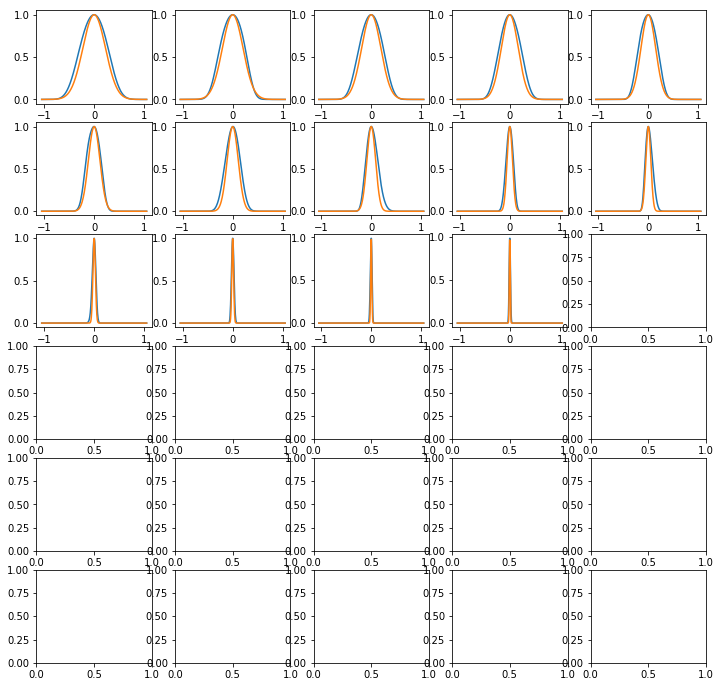

In [239]:
xx = np.linspace(-np.pi/3,np.pi/3,int(2*np.pi/3/0.005))
fig, ax = plt.subplots(ncols=5,nrows=6,figsize=(12,12))
for ii, scan in enumerate(mode_scans):
    if eigenvalues[ii] < 0: continue
    curr_ax = ax.flatten()[ii]
    curr_ax.plot(xx,np.exp(-scan))
    curr_ax.plot(xx,np.exp(-eigenvalues[ii]*(180./np.pi)**1*xx**2))

In [240]:
from numpy.linalg import det
from numpy import heaviside

from scipy.special import logsumexp
from scipy.special import gamma

In [241]:
n = min_map.nangles()
min_E = multifunc(min_dofs)
dos = lambda E: (2.0*np.pi)**(n/2.)*(E-min_E)**(n/2.-1)/gamma(n/2.)/np.sqrt(pseudo_det)*heaviside(E-min_E,0.5)

In [252]:
E = np.linspace(-100,800,9001)
-logsumexp(-(E-min_E), b=dos(E)) - np.log(2*np.pi/3)*n

-20.62041079384439

In [246]:
print n

14


In [248]:
multifunc(min_dofs) - total_log_partition

-20.027009388209073

In [ ]:
sims = ['aaa_uuu', 'aa_uu', 'cc_gg', 'ccc_ggg', 'cc_gg', 'gaa_uuc', 'gac_guc', 'gag_cuc', 'gau_auc', 'ga_uc', 'gcc_ggc', 'gcg_cgc', 'gga_ucc', 'gg_cc', 'ggc_gcc', 'ggg_ccc', 'ggu_acc', 'gu_ac', 'guc_gac', 'guu_aac']

harmonic_E = []
RECCES_E = []
DOS_E = []

E = np.linspace(-100,800,9001)

for sim in sims:
    
    seqs = sim.split('_')
    seq1 = seqs[0]
    seq2 = seqs[1]
    
    fuck = MiningMinima(seq1, seq2)
    
    hist = SingleHistSimulation('./../../../recces_rosetta/results/'+sim+'/ST/')
    
    harmonic_E.append(fuck.harmonic_free_energy)
    RECCES_E.append(hist.value)
    DOS_E.append(-scipy.special.logsumexp(-E, b=fuck.dos(E)))

In [ ]:
print RECCES_E
print harmonic_E
print DOS_E
plt.scatter(RECCES_E, DOS_E)
plt.plot([-45,-15],[-45,-15])

In [ ]:
from recces.util import *
from recces.data import *

In [ ]:
sim = SingleHistSimulation('./../../../recces_rosetta/results/'+seq1+'_'+seq2+'/ST/')

In [ ]:
print sim.value
-np.log(np.trapz(sim._dos, dx=0.1))
'guu_acc'.split('_')

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy

E = np.linspace(-100,100,2001)

plt.plot(E, fuck.dos(E)*np.exp(-E))
plt.plot(sim._dos_scores[:2000], sim._dos[:2000]*np.exp(-sim._dos_scores[:2000]))
plt.xlabel('energy (REU)')
plt.ylabel('$g(E)e^{-E/kT}$')
plt.legend(('MM', 'RECCES'))
print -scipy.special.logsumexp(-E, b=fuck.dos(E)), sim.value, fuck.harmonic_free_energy

In [ ]:
print fuck.anharmonic_free_energy
print fuck.harmonic_free_energy

In [ ]:

print fuck.modes[:,0]
pmm.apply(fuck.min_pose)

In [ ]:
n_struct = 200

ensemble = fuck.harmonic_ensemble(n_struct = n_struct)
#print ensemble[2,:]-min_dofs
#print np.sqrt(H)/np.sqrt((2*np.pi)**fuck.n_dofs)*np.exp(-np.dot(fuck.eigenvalues, ((min_dofs-ensemble[0,:])*np.pi/180)**2)/2)

In [ ]:
pose = Pose()
pose.assign(fuck.min_pose)

hist_min = -100
hist_max = 100
delE = 0.1

hist_scores = np.linspace(hist_min, hist_max, int((hist_max-hist_min)/delE)+1)

hist = np.zeros_like(hist_scores)

for i in range(n_struct):
    
    dofs = ensemble[i,:]
    
    for key in fuck.dof_dict: pose.set_torsion(fuck.dof_dict[key], dofs[key])
        
    energy = fuck.scorefxn(pose)
    
    if energy < hist_max+delE:
             
        hist_idx = math.floor((energy-hist_min)/delE)
        hist_idx = int(hist_idx)
        hist[hist_idx] += 1


In [ ]:
shit = hist*np.exp(hist_scores)/np.sum(hist)
shit = shit/np.sum(shit)
print -scipy.special.logsumexp(-hist_scores, b = shit)
plt.plot(hist_scores, shit*np.exp(-hist_scores)/torsion_volume(seq1, seq2))
plt.plot(sim._dos_scores[:2000], sim._dos[:2000]*np.exp(-sim._dos_scores[:2000]))

In [ ]:
pose = Pose()
pose_new = Pose()
pose.assign(fuck.min_pose)
for key in fuck.dof_dict: pose.set_torsion(fuck.dof_dict[key],ensemble[0,:][key])

pose_new.assign(pose)

E_0 = fuck.scorefxn(fuck.min_pose)
energy = E_0

min_dofs = [fuck.min_pose.torsion(fuck.dof_dict[key]) for key in fuck.dof_dict]
curr_dofs = min_dofs
print min_dofs

Z = 0
H = np.product(fuck.eigenvalues)

for j in range(1,n_struct):
    
    trial_move = ensemble[j, :]
     
    for key in fuck.dof_dict: pose_new.set_torsion(fuck.dof_dict[key], trial_move[key]) 

    energy_new = fuck.scorefxn(pose_new)
    
    if np.exp(-(energy_new-energy)) > np.random.random():
        
        energy = energy_new
        pose.assign(pose_new)
        curr_dofs = trial_move
        
    

        #p = np.sqrt(H/(2*np.pi)**fuck.n_dofs)*np.exp(-np.dot(fuck.eigenvalues, ((trial_move-min_dofs)*(np.pi/180)**2)**2)/2)
    if energy < hist_max+delE:
             
        hist_idx = math.floor((energy-hist_min)/delE)
        hist_idx = int(hist_idx)
        hist[hist_idx] += 1

    

In [ ]:
#plt.plot(hist_scores, hist)
shit = hist/np.sum(hist)
shit = shit*np.exp(hist_scores)
shit = shit/np.sum(shit)
#plt.plot(hist_scores, shit)
plt.plot(hist_scores, hist/np.sum(hist))
print -np.log(np.exp(-E_0)*(0.25)**fuck.n_dofs/0.35)


In [ ]:
print ensemble
pmm = PyMOLMover()
pmm.keep_history(True)
print ensemble[1,:]

In [ ]:
pose = Pose()
pose.assign(fuck.min_pose)

for i in range(200):
    
    dofs = ensemble[i,:]
    for key in fuck.dof_dict: pose.set_torsion(fuck.dof_dict[key], dofs[key]) 
    pmm.apply(pose)
    

In [ ]:
print np.cov(ensemble)

In [ ]:
w,v = np.linalg.eigh(np.cov(ensemble.T))
print fuck.eigenvalues

In [ ]:
print 1/w*180*180/np.pi/np.pi

In [ ]:

print fuck.min_energy - 0.5*fuck.n_dofs*np.log(2*np.pi) + 0.5*np.log(np.prod(1/w))

In [ ]:
print fuck.anharmonic_free_energy

In [ ]:
print fuck.min_pose

In [ ]:
mu = np.zeros(fuck.n_dofs)

In [ ]:
print mu

In [ ]:
mu = [fuck.min_pose.torsion(fuck.dof_dict[key]) for key in fuck.dof_dict]

In [ ]:
print mu
bitch = np.linalg.inv(fuck.hessian)

In [ ]:
shit = np.random.multivariate_normal(mu, bitch, size=(2000))

In [ ]:
print shit[0,:]

In [ ]:
random_struct = np.zeros((fuck.n_dofs, 2000))

for j in range(2000):
    
    random_struct[:,j] = np.random.multivariate_normal(mu, bitch)

In [ ]:
print random_struct

In [ ]:
print np.cov(random_struct)

In [ ]:
w,v = np.linalg.eigh(np.cov(random_struct))

In [ ]:
print 1/w


In [ ]:
cu_ag = MiningMinima('cuc', 'gag')

In [ ]:
cu_ag.harmonic_free_energy

In [ ]:
ensemble = cu_ag.harmonic_ensemble()

In [ ]:
cu_ag.eigenvalues

In [ ]:
np.diag(1/cu_ag.eigenvalues)

In [ ]:
np.matmul( np.matmul( cu_ag.modes, np.diag(1/cu_ag.eigenvalues)), cu_ag.modes.T)

In [ ]:
np.linalg.inv(cu_ag.hessian)